In [5]:
import itertools

import astropy.units as u
import numpy as np
import astropy.time
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
import astropy.constants as const
import sunpy.map

import xrtpy
import aiapy.response

In [6]:
mxrt = sunpy.map.Map('/Users/wtbarnes/sunpy/data/comp_XRT20201109_053212.9.fits')

In [12]:
mxrt.meta['TELESCOP']

'HINODE'

In [13]:
mxrt.measurement

'Open-Al mesh'

In [2]:
from xrtpy.response.effective_area import index_mapping_to_fw1_name, index_mapping_to_fw2_name

In [3]:
index_mapping_to_fw1_name

{'Open': 0, 'Al-poly': 1, 'C-poly': 2, 'Be-thin': 3, 'Be-med': 4, 'Al-med': 5}

In [4]:
index_mapping_to_fw2_name

{'Open': 0,
 'Al-mesh': 1,
 'Ti-poly': 2,
 'G-band': 3,
 'Al-thick': 4,
 'Be-thick': 5}

In [7]:
filters = [
    'Al-poly',
    'Be-thin',
    'Be-med',
    'Be-thick',
]
date = astropy.time.Time('2006-09-22T22:00:00')

## Temperature Response Functions

In [27]:
foo = xrtpy.response.TemperatureResponseFundamental('be-thin', date)

In [28]:
foo.effective_area() * foo.solid_angle_per_pixel * (const.c * const.h / foo.channel_wavelength).to('eV ph-1') / foo.ev_per_electron / foo.ccd_gain_right

<Quantity [3.97869957e-19, 1.03260460e-18, 2.46082912e-18, ...,
           1.55966159e-51, 0.00000000e+00, 0.00000000e+00] cm2 DN sr / (ph pix)>

In [12]:
foo.ev_per_electron

<Quantity 3.6500001 eV / electron>

In [13]:
foo.ccd_gain_right

<Quantity 59.09999847 electron / DN>

In [20]:
foo.channel_wavelength

<Quantity [  1.   ,   1.1  ,   1.2  , ..., 399.787, 399.893, 400.   ] Angstrom ph>

In [30]:
foo.channel_wavelength

<Quantity [  1.   ,   1.1  ,   1.2  , ..., 399.787, 399.893, 400.   ] Angstrom ph>

In [4]:
temp_response = {}
for f in filters:
    resp = xrtpy.response.TemperatureResponseFundamental(f, date)
    temp_response[resp.name] = (resp.CHIANTI_temperature, resp.temperature_response()) 

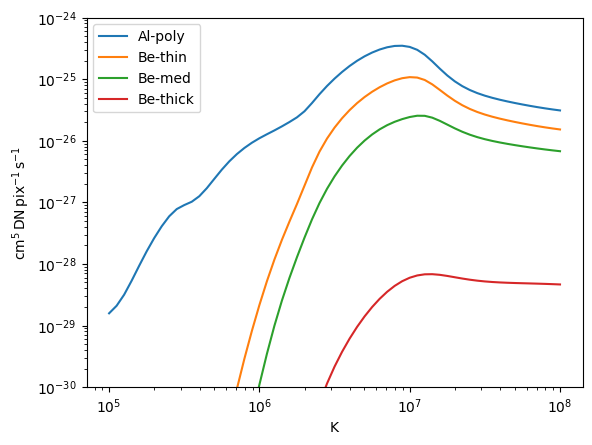

In [79]:
with quantity_support():
    for f in temp_response:
        plt.plot(*temp_response[f], label=f)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-30,1e-24)
plt.legend()

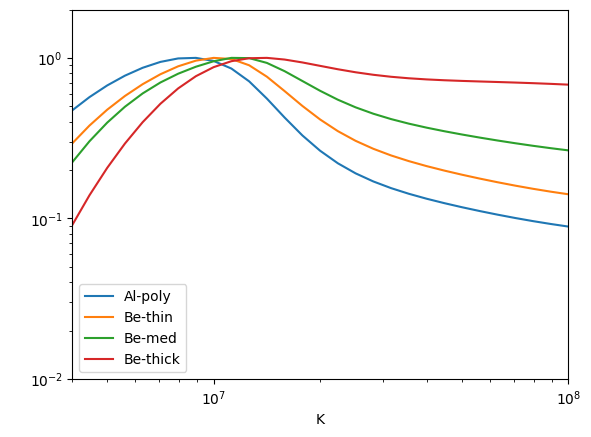

In [80]:
with quantity_support():
    for f in temp_response:
        T,tr = temp_response[f]
        plt.plot(T, tr/tr.max(), label=f)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,2)
plt.xlim(4e6,1e8)
plt.legend()

In [8]:
pairs = [sorted(p) for p in itertools.product(filters,filters,) if p[0] != p[1]]
pairs = set(['/'.join(p) for p in pairs])
pairs = [p.split('/') for p in pairs]

In [109]:
pairs

[['Al-poly', 'Be-thick'],
 ['Be-med', 'Be-thin'],
 ['Be-thick', 'Be-thin'],
 ['Be-med', 'Be-thick'],
 ['Al-poly', 'Be-med'],
 ['Al-poly', 'Be-thin']]

In [110]:
pairs = [
    ['Al-poly', 'Be-thick'],
    ['Be-thin', 'Be-med'],
    ['Be-thin', 'Be-thick'],
    ['Be-med', 'Be-thick'],
    ['Al-poly', 'Be-med'],
    ['Al-poly', 'Be-thin'] 
]

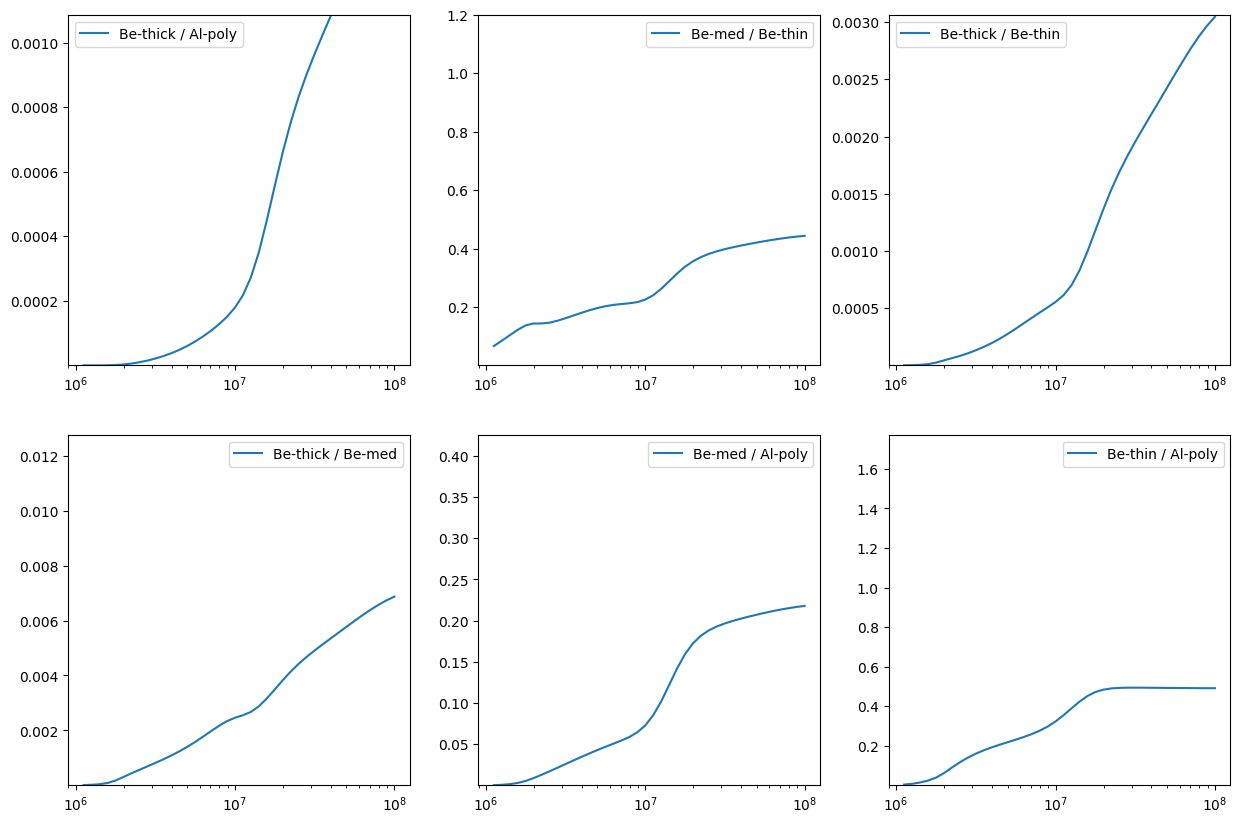

In [111]:
fig = plt.figure(figsize=(15,10))
for i,(pa,pb) in enumerate(pairs):
    Ta,tra = temp_response[pa]
    Tb,trb = temp_response[pb]
    i_T = np.where(Ta > 1e6*u.K)
    ratio = trb.to_value('cm5 DN pix-1 s-1')/tra.to_value('cm5 DN pix-1 s-1')
    ratio = ratio[i_T]
    #ratio_grad = np.gradient(ratio, np.gradient(log_T))
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(Ta[i_T], ratio, label=f'{pb} / {pa}')
    ax.set_xscale('log')
    ax.set_ylim(ratio[(ratio.shape[0] + 1)//2]*np.array([0.01,5]))
    ax.legend()
#plt.xlim(1e6,1e8)
#plt.ylim(1e-10,1e10)
#plt.legend(ncol=2)
#plt.axhline(y=1,color='k',ls=':',)

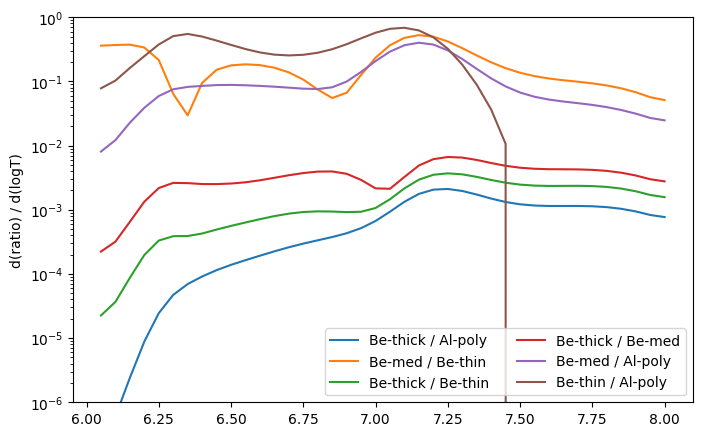

In [121]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
for pa,pb in pairs[:]:
    Ta,tra = temp_response[pa]
    Tb,trb = temp_response[pb]
    i_T = np.where(Ta > 1e6*u.K)
    ratio = trb.to_value('cm5 DN pix-1 s-1')/tra.to_value('cm5 DN pix-1 s-1')
    Ta = Ta[i_T]
    ratio = ratio[i_T]
    log_T = np.log10(Ta.to_value())
    ratio_grad = np.gradient(ratio, log_T) 
    ax.plot(log_T, ratio_grad, label=f'{pb} / {pa}')
#ax.set_xscale('log')
#ax.set_yscale('symlog',linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim(1e-6,1)
ax.set_ylabel('d(ratio) / d(logT)')
ax.legend(ncol=2)
plt.axhline(y=0,color='k',ls=':',)